##### Clip the .tif file

In [2]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.features import shapes
from shapely.geometry import box
from shapely.geometry import shape
import matplotlib.pyplot as plt
from tqdm import tqdm
from osgeo import gdal
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

Clipped raster saved successfully.


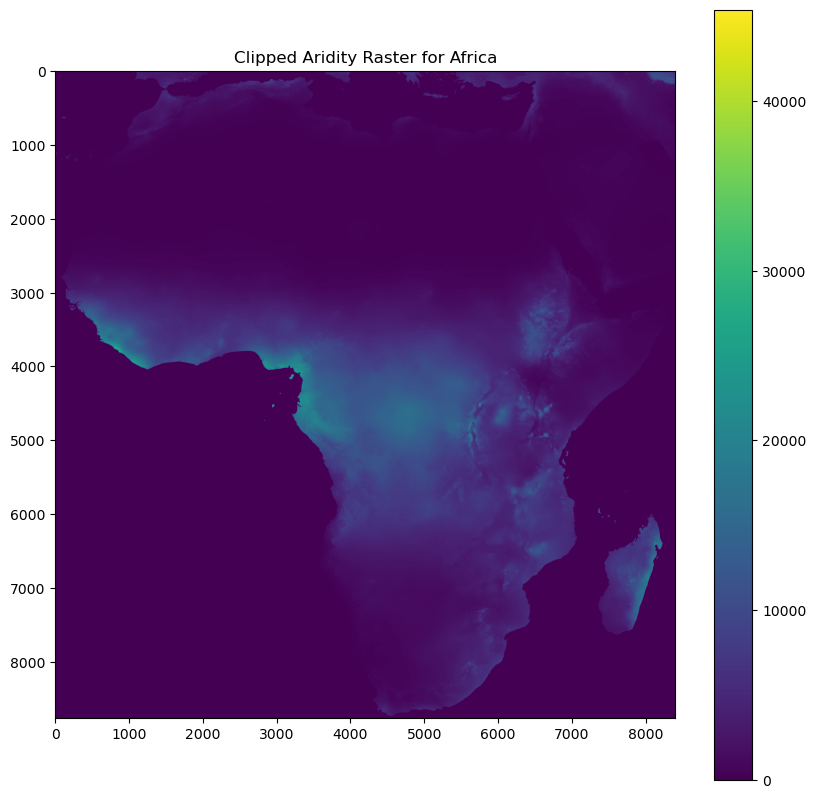

Value at coordinates (1000, 8000): 0


In [3]:
# Load the raster file and define the bounding box for Africa
with rasterio.open(resolve_path(config['Global_Aridity_Raster_path'])) as src:

    # Define the bounding box for Africa (in degrees)
    minx, miny = -18.0, -35.0  # approximate coordinates for Africa
    maxx, maxy = 52.0, 38.0

    # Create a bounding box polygon
    bbox = box(minx, miny, maxx, maxy)
    bbox_gdf = gpd.GeoDataFrame({'geometry': [bbox]}, index=[0], crs=src.crs)

    # Clip the raster to the bounding box
    out_image, out_transform = mask(src, bbox_gdf.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    clipped_tif_path = resolve_path(config['Africa_Arid_Regions_tif_path'])
    with rasterio.open(clipped_tif_path, "w", **out_meta) as dest:
        dest.write(out_image)

    print("Clipped raster saved successfully.")

with rasterio.open(clipped_tif_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    raster_data = src.read(1)
    im = ax.imshow(raster_data, cmap='viridis')
    ax.set_title("Clipped Aridity Raster for Africa")
    plt.colorbar(im, ax=ax)
    plt.show()

    # Access pixel value at coordinates (1000, 8000)
    x_coord, y_coord = 1000, 8000
    if x_coord < raster_data.shape[0] and y_coord < raster_data.shape[1]:
        value = raster_data[x_coord, y_coord]
        print(f"Value at coordinates ({x_coord}, {y_coord}): {value}")
    else:
        print(f"Coordinates ({x_coord}, {y_coord}) are out of bounds for the raster of shape {raster_data.shape}")

##### Resample and convert to a (much too large) shapefile

In [3]:
# Enable GDAL exceptions
gdal.UseExceptions()

# Read the trimmed Africa aridity index tif file
aridity_tif = resolve_path(config['Africa_Arid_Regions_tif_path'])  # Replace with the path to your file
ds = gdal.Open(aridity_tif)
if ds is None:
    raise ValueError("Could not open the dataset. Please check the file path.")

# Resample the dataset to a lower resolution to make processing faster
resample_scale = 0.1  # Resample scale factor (e.g., 0.1 for 10% of the original size)
width = int(ds.RasterXSize * resample_scale)
height = int(ds.RasterYSize * resample_scale)
resampled_aridity_data = ds.ReadAsArray(buf_xsize=width, buf_ysize=height)

# Filter the aridity data for values < 5000 (0.5 * 10000) using vectorized operations
filtered_aridity_data = np.where((resampled_aridity_data < 5000) & (resampled_aridity_data > 0), resampled_aridity_data, np.nan).astype(np.float32)

# Use rasterio and shapes directly on the filtered array
with rasterio.open(aridity_tif) as src:
    transform = src.transform
    # Adjust the transform to account for the resampling
    resampled_transform = src.transform * src.transform.scale(
        (src.width / width),
        (src.height / height)
    )
    shapes_generator = shapes(filtered_aridity_data, mask=~np.isnan(filtered_aridity_data), transform=resampled_transform)

# Create a GeoDataFrame
geoms = []
valid_shape_count = 0
for shp, val in tqdm(shapes_generator, desc="Generating shapes"):
    if val < 5000:
        geoms.append(shape(shp))
        valid_shape_count += 1
        if valid_shape_count % 10000 == 0:
            print(f"Processed {valid_shape_count} shapes")

gdf = gpd.GeoDataFrame(geometry=geoms)

# Save the GeoDataFrame as a shapefile
output_path = resolve_path(config['Africa_Arid_Regions_shp_path'])
print(f"Saving shapefile to {output_path}")
#gdf.to_file(output_path)
#print("Shapefile saved successfully")


Generating shapes: 0it [00:00, ?it/s]

Generating shapes: 19427it [00:00, 34014.17it/s]

Processed 10000 shapes


Generating shapes: 29019it [00:01, 41012.79it/s]

Processed 20000 shapes
Processed 30000 shapes


Generating shapes: 48474it [00:01, 46423.88it/s]

Processed 40000 shapes


Generating shapes: 57958it [00:01, 45708.09it/s]

Processed 50000 shapes


Generating shapes: 67220it [00:01, 45699.81it/s]

Processed 60000 shapes


Generating shapes: 76459it [00:02, 45720.01it/s]

Processed 70000 shapes


Generating shapes: 85652it [00:02, 41748.20it/s]

Processed 80000 shapes


Generating shapes: 94906it [00:02, 44015.86it/s]

Processed 90000 shapes


Generating shapes: 109289it [00:02, 46531.04it/s]

Processed 100000 shapes


Generating shapes: 119021it [00:03, 47550.81it/s]

Processed 110000 shapes
Processed 120000 shapes


Generating shapes: 138991it [00:03, 49439.29it/s]

Processed 130000 shapes
Processed 140000 shapes


Generating shapes: 158813it [00:03, 49404.79it/s]

Processed 150000 shapes
Processed 160000 shapes


Generating shapes: 178602it [00:04, 44510.02it/s]

Processed 170000 shapes


Generating shapes: 188354it [00:04, 46557.68it/s]

Processed 180000 shapes


Generating shapes: 198258it [00:04, 48119.84it/s]

Processed 190000 shapes
Processed 200000 shapes


Generating shapes: 218545it [00:05, 49639.22it/s]

Processed 210000 shapes
Processed 220000 shapes


Generating shapes: 238372it [00:05, 49032.18it/s]

Processed 230000 shapes


Generating shapes: 243279it [00:05, 48989.47it/s]

Processed 240000 shapes


Generating shapes: 247713it [00:05, 42800.19it/s]


Saving shapefile to /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid_Regions-shp


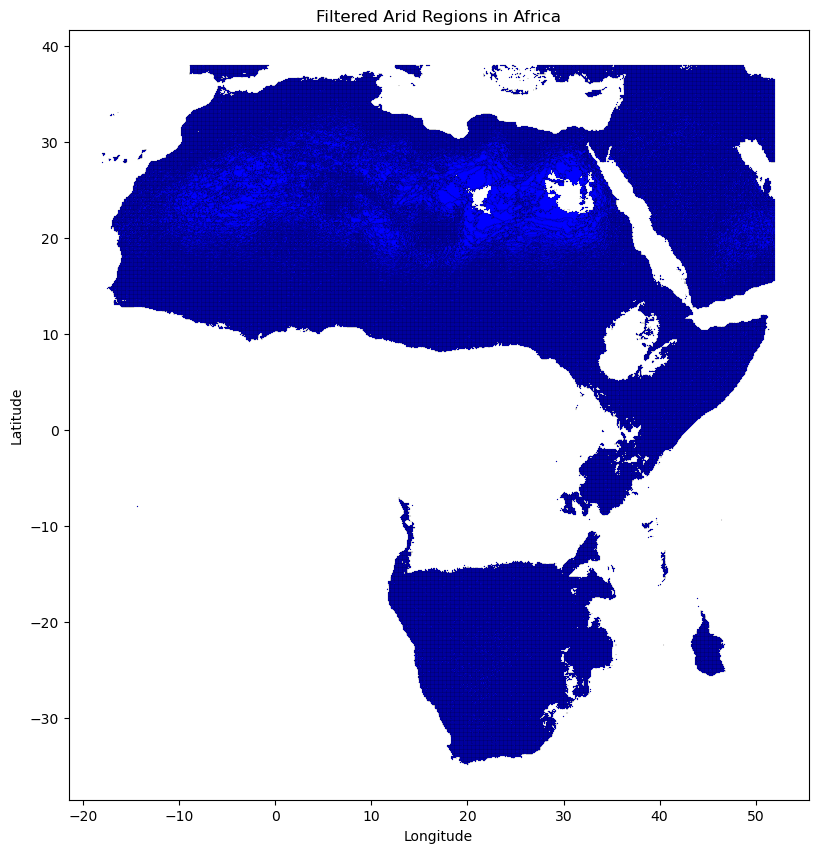

In [4]:
# Path to the saved shapefile
shapefile_path = resolve_path(config['Africa_Arid_Regions_shp_path'])

# Read the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='blue', edgecolor='k', linewidth=0.1)
ax.set_title("Filtered Arid Regions in Africa")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()


##### Create a shapefile we can actually work with

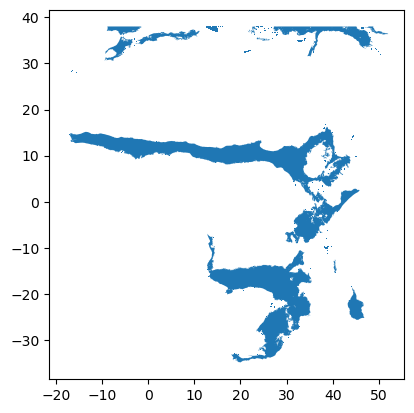

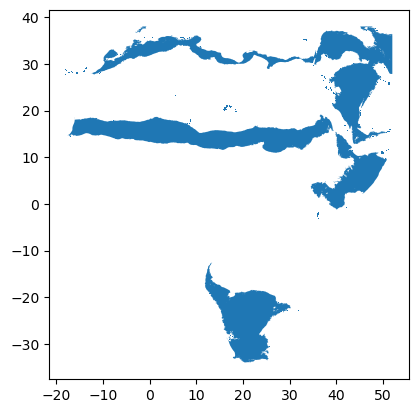

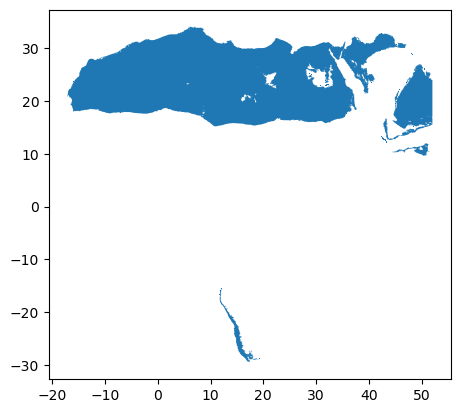

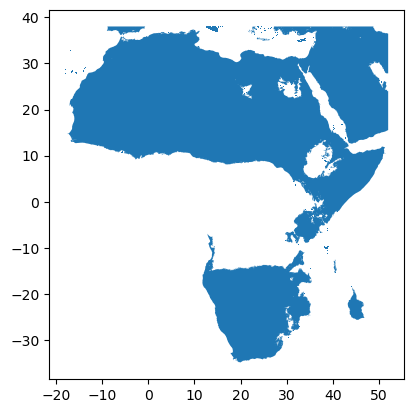

In [5]:
# Load the .tif file
tif_path = resolve_path(config['Africa_Arid_Regions_tif_path'])
with rasterio.open(tif_path) as src:
    data = src.read(1)
    profile = src.profile

# Replace NaN values with 0
data = np.nan_to_num(data, nan=0)

# Mask out data greater than 5000 (data > 5000 set to 0)
data_masked = np.where(data > 5000, 0, data)

# Define aridity levels
arid_classes = {
    'semi_arid': (2000, 5000),
    'arid': (300, 2000),
    'hyper_arid': (0, 300),
    'all': (0, 5000)
}

# Create a mask for each aridity level
masks = {key: np.where((data_masked > val[0]) & (data_masked < val[1]), 1, 0) for key, val in arid_classes.items()}

# Create a mask for all data within the aridity range (< 5000)
masks['all'] = np.where(data_masked > 0, 1, 0)  # Mask for all data <= 5000

def create_shapefile(mask, profile, output_path):
    # Convert mask to uint8
    mask_uint8 = mask.astype('uint8')
    
    # Extract shapes
    shapes_gen = shapes(mask_uint8, transform=profile['transform'])
    geoms = [shape(geom) for geom, value in shapes_gen if value == 1]
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=geoms)
    
    # Save to shapefile
    gdf.to_file(output_path)

    gdf.plot()
    plt.show()

# Create shapefiles for each mask
for key, mask in masks.items():
    create_shapefile(mask, profile, resolve_path(config[f'Africa_{key}_shp_path']))

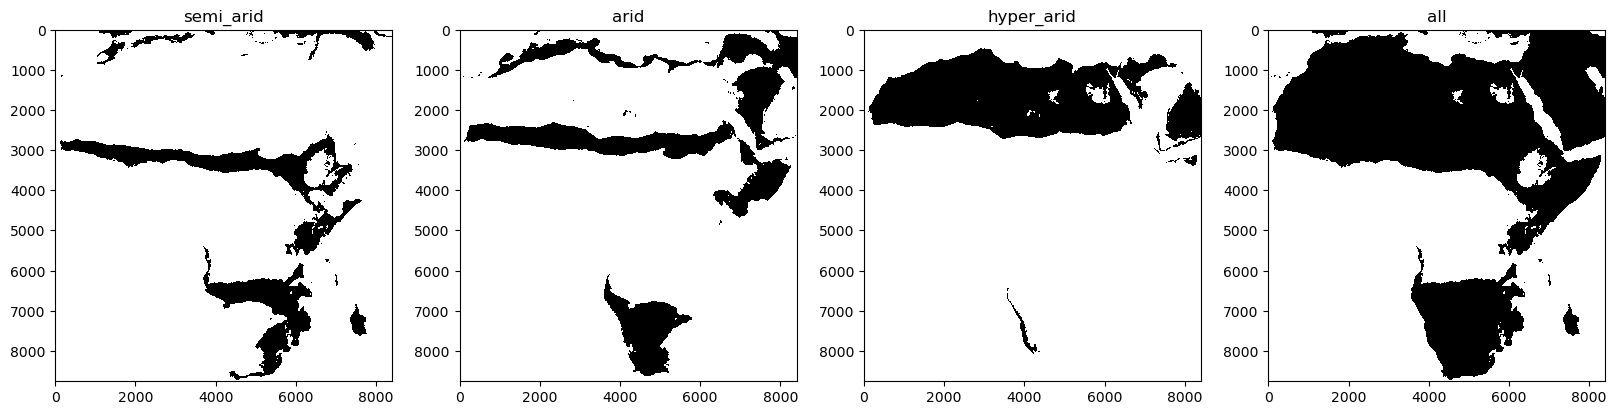

In [6]:
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(['white', 'black'])
norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# Plot masks
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i, (key, mask) in enumerate(masks.items()):
    masked_array = np.ma.masked_invalid(mask)
    axes[i].imshow(masked_array, cmap=cmap, norm=norm)
    axes[i].set_title(key)
plt.show()

##### Get continent outline from Africa_Boundaries

In [1]:
# Load the Africa boundaries shapefile
print("Loading Africa boundaries shapefile...")
africa_boundaries_path = resolve_path(config['Africa_boundaries_shp_path'])
africa_gdf = gpd.read_file(africa_boundaries_path)

# Add a dummy column for dissolving
print("Adding dummy column for dissolving...")
africa_gdf['continent'] = 'Africa'

# Dissolve the boundaries to get a single outline for the continent
print("Dissolving boundaries to get single outline of the continent...")
africa_continent = africa_gdf.dissolve(by='continent')

# Set the CRS of the dissolved outline to EPSG:4326
print("Setting CRS for dissolved outline...")
africa_continent.set_crs(epsg=4326, inplace=True)

# Plot the continent outline to verify
print("Plotting the continent outline to verify...")
africa_continent.plot()
plt.title('Outline of the African Continent')
plt.show()
print(africa_continent.head())

Loading Africa boundaries shapefile...


NameError: name 'resolve_path' is not defined

Loading and checking CRS of aridity shapefiles...
CRS of /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Semi_Arid-shp: EPSG:4326
CRS of /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid-shp: EPSG:4326
CRS of /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Hyper_Arid-shp: EPSG:4326
CRS of /home/ermiller/Africa_Irrigation/Data/Processed/Africa_Arid_Regions_All-shp: EPSG:4326
Masking aridity shapefiles using the Africa outline...


Masking shapefiles:   0%|          | 0/4 [00:00<?, ?it/s]

Starting mask operation for a shapefile...


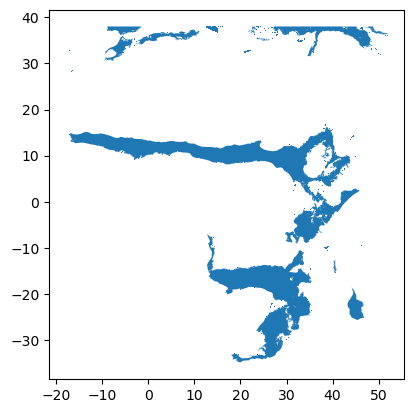

In [8]:

def load_and_check_crs(shapefile_path):
    gdf = gpd.read_file(shapefile_path)
    gdf.set_crs(epsg = 4326, inplace = True)
    print(f"CRS of {shapefile_path}: {gdf.crs}")
    return gdf

# Load each shapefile and check CRS
print("Loading and checking CRS of aridity shapefiles...")
aridity_gdfs = {}
for key, mask in masks.items():
    aridity_gdfs[key] = load_and_check_crs(resolve_path(config[f'Africa_{key}_shp_path']))

# Function to mask shapefiles using the Africa outline
def mask_shapefile_with_continent(gdf, outline):
    print("Starting mask operation for a shapefile...")
    gdf.plot()
    plt.show()

    # Perform spatial join to keep only the data within the outline
    masked_gdf = gpd.overlay(gdf, outline, how='intersection')
    print("Completed mask operation for a shapefile.")
    masked_gdf.plot()
    plt.show()
    return masked_gdf


# Mask each shapefile using the Africa outline with progress bar
print("Masking aridity shapefiles using the Africa outline...")
masked_aridity_gdfs = {}
for key, gdf in tqdm(aridity_gdfs.items(), desc="Masking shapefiles"):
    masked_aridity_gdfs[key] = mask_shapefile_with_continent(gdf, africa_continent)

